## EE232E Project 3 Reinforcement Learning and Inverse Reinforcement Learning

### Part 1 Reinforcement Learning

In [16]:
import matplotlib
matplotlib.use('TkAgg')
import math
import numpy as np
import seaborn as sns
from cvxopt import matrix, solvers

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
######################################################################
# global variables definition
######################################################################
number_of_states = 100
actions = {1: [0, -1], 2: [0, 1], 3: [-1, 0], 4: [0, 1]}
w = 0.1
discount_factor = 0.8
A = [[-1, 0], [1, 0], [0, -1], [0, 1]]

In [4]:
reward_function1 = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])


In [5]:
reward_function2 = np.array([[0.0, 0.0, 0.0, 0.0,   0.0,    0.0,    0.0,    0.0,    0.0,  0.0],
                     [0.0, 0.0, 0.0, 0.0, -100.0, -100.0, -100.0,    0.0,    0.0,  0.0],
                     [0.0, 0.0, 0.0, 0.0, -100.0,    0.0, -100.0,    0.0,    0.0,  0.0],
                     [0.0, 0.0, 0.0, 0.0, -100.0,    0.0, -100.0, -100.0, -100.0,  0.0],
                     [0.0, 0.0, 0.0, 0.0, -100.0,    0.0,    0.0,    0.0, -100.0,  0.0],
                     [0.0, 0.0, 0.0, 0.0, -100.0,    0.0,    0.0,    0.0, -100.0,  0.0],
                     [0.0, 0.0, 0.0, 0.0, -100.0,    0.0,    0.0,    0.0, -100.0,  0.0],
                     [0.0, 0.0, 0.0, 0.0,    0.0,    0.0, -100.0, -100.0, -100.0,  0.0],
                     [0.0, 0.0, 0.0, 0.0,    0.0,    0.0, -100.0,    0.0,    0.0,  0.0],
                     [0.0, 0.0, 0.0, 0.0,    0.0,    0.0,    0.0,    0.0,    0.0, 10.0]])



In [6]:
######################################################################
# functions
######################################################################
# to see if trasition out of bound
def check(state, next_state):
    if next_state < 0 or next_state > 99:
        return False
    elif state % 10 == 9 and next_state % 10 == 0:
        return False
    elif state % 10 == 0 and next_state % 10 == 9:
        return False
    return True

In [7]:
def tran_matrix(A):
    P_ss_a = np.zeros((100, 100, 4))
    P_ss_a = P_ss_a.astype(float)

    # for non-boundary state
    w = 0.1
    for a in range(4):
        for i in range(1, 9):
            for j in range(1, 9):
                for action in range(4):
                    state = i * 10 + j
                    next_state = (i + A[action][0]) * 10 + j + A[action][1]
                    P_ss_a[state, next_state, a] = (1 - (3 * w) / 4) if (action == a) else (w / 4)

        # for corner state
        for i in [0, 9]:
            for j in [0, 9]:
                for action in range(4):
                    state = i * 10 + j
                    next_state = (i + A[action][0]) * 10 + j + A[action][1]
                    if check(state, next_state):
                        P_ss_a[state, next_state, a] = (1 - (3 * w) / 4) if (action == a) else (w / 4)
                    else:
                        P_ss_a[state, state, a] += (1 - (3 * w) / 4) if (action == a) else (w / 4)

        # for edge state
        for i in [0, 9]:
            for j in range(1, 9):
                for action in range(4):
                    state = i * 10 + j
                    next_state = (i + A[action][0]) * 10 + j + A[action][1]
                    if check(state, next_state):
                        P_ss_a[state, next_state, a] = (1 - (3 * w) / 4) if (action == a) else (w / 4)
                    else:
                        P_ss_a[state, state, a] = (1 - (3 * w) / 4) if (action == a) else (w / 4)
        for i in range(1, 9):
            for j in [0, 9]:
                for action in range(4):
                    state = i * 10 + j
                    next_state = (i + A[action][0]) * 10 + j + A[action][1]
                    if check(state, next_state):
                        P_ss_a[state, next_state, a] = (1 - (3 * w) / 4) if (action == a) else (w / 4)
                    else:
                        P_ss_a[state, state, a] = (1 - (3 * w) / 4) if (action == a) else (w / 4)

    return P_ss_a


In [8]:
def heatmap_plot(reward_function):
    """
    plot reward_function's heatmap
    :param reward_function: np.array
    :return: heatmap of the reward_function
    """
    heatmap = sns.heatmap(reward_function, cmap="PuBu")
    plt.show()


In [9]:
def gridmap_plot(map, type):
    """
    give a 2d gridmap of state value or policy map
    :param map: map of state value or policy
    :param type: boolean. If true, plot value graph, if false, plot direction graph
    :return: a grid map
    """
    plt.figure()
    if(type):
        row = map.shape[0]
        column = map.shape[1]
        table = plt.table(cellText=np.around(map, decimals=2), loc=(0, 0), cellLoc='center')
    else:
        row = len(map)
        column = len(map[0])
        table = plt.table(cellText=map, loc=(0, 0), cellLoc='center')
    gridmap = table.properties()['child_artists']
    for cell in gridmap:
        cell.set_height(1 / 10.0)
        cell.set_width(1 / 10.0)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [10]:
def estimation_summation(w, reward_function, discount_factor, row, column, state_map):
    """
    compute the max value of different action taken at each state
    :param w: double
    :param reward_function: np.array
    :param discount_factor: double
    :param row: int
    :param column: int
    :param state_map: np.array
    :return: updated state and action
    """
    up_summation = 0
    down_summation = 0
    left_summation = 0
    right_summation = 0

    if(row==0 and column==0):
        up_summation = 0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +(1-0.5*w)*(reward_function[row][column]+discount_factor*state_map[row][column])
        down_summation = 0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])\
                         +(1-0.75*w)*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                         +0.5*w*(reward_function[row][column]+discount_factor*state_map[row][column])
        left_summation = 0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])\
                         +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                         +(1-0.5*w)*(reward_function[row][column]+discount_factor*state_map[row][column])
        right_summation = (1-0.75*w)*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])\
                          +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                          +0.5*w*(reward_function[row][column]+discount_factor*state_map[row][column])

    elif(row==0 and column==9):
        up_summation = 0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +(1-0.5*w)*(reward_function[row][column]+discount_factor*state_map[row][column])
        down_summation = 0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                         +(1-0.75*w)*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                         +0.5*w*(reward_function[row][column]+discount_factor*state_map[row][column])
        left_summation = (1-0.75*w)*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                         +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                         +0.5*w*(reward_function[row][column]+discount_factor*state_map[row][column])
        right_summation = 0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                         +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                         +(1-0.5*w)*(reward_function[row][column]+discount_factor*state_map[row][column])


    elif(row==9 and column==0):
        up_summation = (1-0.75*w)*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])\
                       +0.5*w*(reward_function[row][column]+discount_factor*state_map[row][column])
        down_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                         +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])\
                         +(1-0.5*w)*(reward_function[row][column]+discount_factor*state_map[row][column])
        left_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                         +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])\
                         +(1-0.5*w)*(reward_function[row][column]+discount_factor*state_map[row][column])
        right_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                         +(1-0.75*w)*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])\
                         +0.5*w*(reward_function[row][column]+discount_factor*state_map[row][column])

    elif(row==9 and column==9):
        up_summation = (1-0.75*w)*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.5*w*(reward_function[row][column]+discount_factor*state_map[row][column])
        down_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                         +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                         +(1-0.5*w)*(reward_function[row][column]+discount_factor*state_map[row][column])
        left_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                         +(1-0.75*w)*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                         +0.5*w*(reward_function[row][column]+discount_factor*state_map[row][column])
        right_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                         +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                         +(1-0.5*w)*(reward_function[row][column]+discount_factor*state_map[row][column])

    elif(row==0 and column>0 and column<9):
        up_summation = (1-0.75*w)*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        down_summation = 0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +(1-0.75*w)*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        left_summation = 0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +(1-0.75*w)*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        right_summation = 0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +(1-0.75*w)*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])

    elif(column==0 and row>0 and row<9):
        up_summation = (1-0.75*w)*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        down_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +(1-0.75*w)*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        left_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +(1-0.75*w)*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        right_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +(1-0.75*w)*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])

    elif(row==9 and column>0 and column<9):
        up_summation = (1-0.75*w)*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        down_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +(1-0.75*w)*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        left_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +(1-0.75*w)*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        right_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +(1-0.75*w)*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])

    elif(column==9 and row>0 and row<9):
        up_summation = (1-0.75*w)*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])
        down_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +(1-0.75*w)*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])
        left_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +(1-0.75*w)*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column]+discount_factor*state_map[row][column])
        right_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +(1-0.75*w)*(reward_function[row][column]+discount_factor*state_map[row][column])

    else:
        up_summation = (1-0.75*w)*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        down_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +(1-0.75*w)*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        left_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +(1-0.75*w)*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +0.25*w*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
        right_summation = 0.25*w*(reward_function[row-1][column]+discount_factor*state_map[row-1][column])\
                       +0.25*w*(reward_function[row+1][column]+discount_factor*state_map[row+1][column])\
                       +0.25*w*(reward_function[row][column-1]+discount_factor*state_map[row][column-1])\
                       +(1-0.75*w)*(reward_function[row][column+1]+discount_factor*state_map[row][column+1])
    summations = [up_summation, down_summation, left_summation, right_summation]
    return max(summations), summations.index(max(summations))


In [11]:
def optimal_state_value(w, reward_function, number_of_states, discount_factor, epsilon):
    """
    taking environment variables and output the optimal state values
    :param w: double
    :param reward_function: np.array
    :param number_of_states: np.array
    :param actions: dictionary
    :param discount_factor: double
    :param epsilon: stopping criterion
    :return:optimal values of state map
    """
    rows = int(math.sqrt(number_of_states))
    columns = int(math.sqrt(number_of_states))
    state_map = np.zeros((rows, columns))

    delta = 10000000
    i = 0
    while delta > epsilon and i<1000:
        delta = 0
        i = i+1
        for row in range(rows):
            for column in range(columns):
                value = state_map[row][column]
                state_map[row][column], action = estimation_summation(w, reward_function, discount_factor, row, column, state_map)
                delta = max(delta, abs(value-state_map[row][column]))
    return state_map

In [12]:
def convertArrowToNumber(policy):
    [rows, cols] = policy.shape
    policyTemp=np.zeros((rows, cols))
    for i in range(rows - 1):
        for j in range(cols - 1):
            if(policy[i][j]==u'↑'):
                policyTemp[i][j]=int(2)
            if (policy[i][j] == u'↓'):
                policyTemp[i][j] = int(3)
            if (policy[i][j] == u'←'):
                policyTemp[i][j] = int(0)
            if (policy[i][j] == u'→'):
                policyTemp[i][j] = int(1)
    return policyTemp.astype(int)

In [39]:
# computatation step, with output of arrows
def computation(w, reward_function, number_of_states, discount_factor, state_map):
    """
    computation step, find the optimal policy
    :param w: double
    :param reward_function: np.array
    :param number_of_states: int
    :param discount_factor: double
    :param state_map: np.array
    :return: optimal policy of each state
    """
    arrowlist = [u'↑', u'↓', u'←',  u'→']
    rows = int(math.sqrt(number_of_states))
    columns = int(math.sqrt(number_of_states))
    policy = []

    for row in range(rows):
        policy.append([])
        for column in range(columns):
            value, action = estimation_summation(w, reward_function, discount_factor, row, column, state_map)
            policy[row].append(arrowlist[action])
    return policy


In [14]:
# new computation function that can output number directely
def computation2(w, reward_function, number_of_states, discount_factor, state_map):
    """
    computation step, find the optimal policy
    :param w: double
    :param reward_function: np.array
    :param number_of_states: int
    :param discount_factor: double
    :param state_map: np.array
    :return: optimal policy of each state
    """

    rows = int(math.sqrt(number_of_states))
    columns = int(math.sqrt(number_of_states))
    policy = []

    for row in range(rows):
        policy.append([])
        for column in range(columns):
            value, action = estimation_summation(w, reward_function, discount_factor, row, column, state_map)
            if action == 0:
                action = 2
            elif action == 1:
                action = 3
            elif action == 2:
                action = 0
            elif action == 3:
                action = 1
            policy[row].append(action)
    policy = np.array(policy)
    policy = policy.ravel(order = 'F')
    return policy


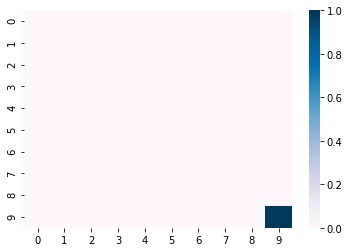

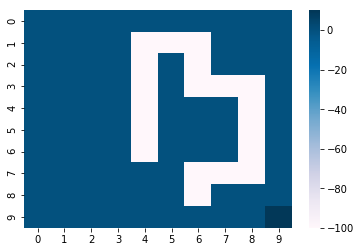

In [101]:
# question 1
heatmap_plot(reward_function1);
heatmap_plot(reward_function2);

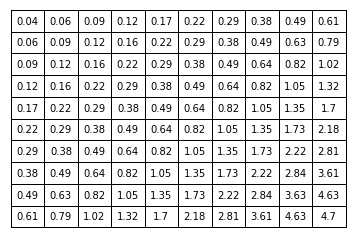

In [102]:
# question 2
state_value_func_1 = optimal_state_value(w=w, reward_function=reward_function1, number_of_states=100, discount_factor=discount_factor, epsilon=0.01);
# print(state_map)
gridmap_plot(map=state_value_func_1, type=True);

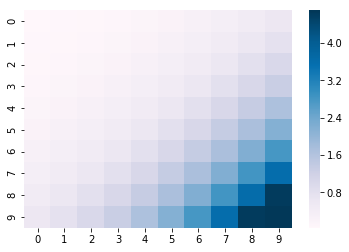

In [103]:
# question 3
heatmap_plot(state_value_func_1);

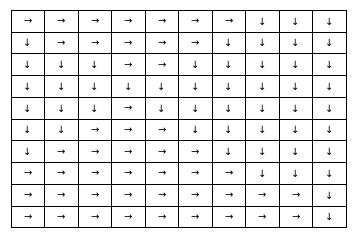

In [104]:
# question 5
opt_policy_1 = computation(w=w, reward_function=reward_function1, number_of_states=100, discount_factor=discount_factor, state_map=state_value_func_1);
gridmap_plot(map=opt_policy_1, type=False)

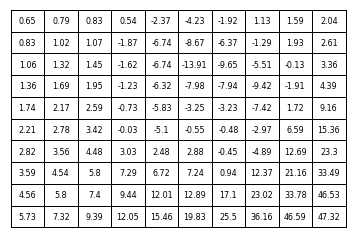

In [105]:
# question 6
state_value_func_2 = optimal_state_value(w=w, reward_function=reward_function2, number_of_states=100, discount_factor=discount_factor, epsilon=0.01);
# print(state_map)
gridmap_plot(map=state_value_func_2, type=True);

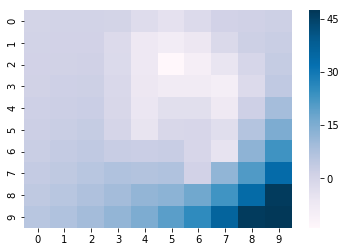

In [106]:
# question 7
heatmap_plot(state_value_func_2);

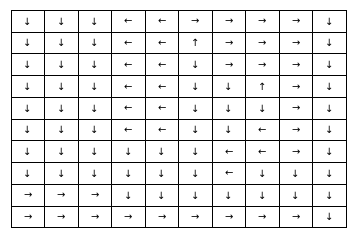

In [107]:
# question 9
opt_policy_2 = computation(w=w, reward_function=reward_function2, number_of_states=100, discount_factor=discount_factor, state_map=state_value_func_2);
gridmap_plot(map=opt_policy_2, type=False)

### Part 2: Inverse Reinforcement Learning

In [45]:
"""
IRL Function parameters:

n_states: Number of states. int.
n_actions: Number of actions. int.
transition_probability: Shape (A, N, N).
policy: Containing the best action in each state. Shape (N,).
Rmax: Maximum reward. float.
lamb: l1 regularisation. float.
"""
def IRL(n_states, n_actions, transition_probability, policy, discount, Rmax, lamb):
    A = set(range(n_actions))

    # Define the function that we always use in this problem
    def T(a, s):
        t1 = transition_probability[policy[s], s] - transition_probability[a, s]
        t2 = np.linalg.inv(np.eye(n_states) - discount * transition_probability[policy[s]])
        return np.dot(t1, t2)

    # creat c as we get in Q10
    c = -np.hstack([np.zeros(n_states), np.ones(n_states), -lamb * np.ones(n_states)])

    # creat D as we get in Q10
    # creat each block in D
    T_stack = np.vstack([
        -T(a, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])

    I_stack1 = np.vstack([
        np.eye(1, n_states, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])

    zero_stack1 = np.zeros((n_states * (n_actions - 1), n_states))

    I_stack2 = np.identity(n_states)

    zero_stack2 = np.zeros((n_states, n_states))

    # construct these blocks by Q10
    D_1 = np.vstack([T_stack, T_stack, -I_stack2, I_stack2])
    D_2 = np.vstack([I_stack1, zero_stack1, zero_stack2, zero_stack2])
    D_3 = np.vstack([zero_stack1, zero_stack1, -I_stack2, -I_stack2])

    D = np.hstack([D_1, D_2, D_3])

    # add Rm block
    D_bounds1 = np.vstack([-np.identity(n_states), np.identity(n_states)])
    D_bounds2 = np.vstack([np.zeros((n_states, n_states)), np.zeros((n_states, n_states))])
    D_bounds = np.hstack([D_bounds1, D_bounds2, D_bounds2])

    # get D
    D = np.vstack((D, D_bounds))

    # creat b as we get in Q10
    b = np.zeros((n_states * (n_actions - 1) * 2 + 2 * n_states, 1))
    b_bounds = np.vstack([Rmax * np.ones((n_states, 1))] * 2)
    b = np.vstack((b, b_bounds))

    D = matrix(D)
    b = matrix(b)
    c = matrix(c)
    solvers.options['show_progress'] = False
    results = solvers.lp(c, D, b)
    

    r = np.asarray(results["x"][:n_states], dtype=np.double)

    return r.reshape((10, 10)).T


In [46]:
'''
des: q11
param: reward_function,shape = 10*10 
return: list Accuracy with 500 entries associated with 500 lambda range from 0 to 5
'''
def getAccuracy(reward_function):
    state_map = optimal_state_value(w=w, reward_function=reward_function, number_of_states=100,
                                    discount_factor=discount_factor, epsilon=0.01);
    policy = computation2(w=w, reward_function=reward_function, number_of_states=100, discount_factor=discount_factor,
                          state_map=state_map);

    accuracy = []
    P_ss_a = tran_matrix(A)
    P_ss_a = np.transpose(P_ss_a, (2, 0, 1))
    h = np.zeros((100, 100, 4))
    i = 0;

    for lam in np.arange(0, 5, 0.01):
        rewardTemp = IRL(100, 4, P_ss_a, policy, discount_factor, reward_function.max(), lam)
        state_mapTemp = optimal_state_value(w=w, reward_function=rewardTemp, number_of_states=100,
                                            discount_factor=discount_factor, epsilon=0.01);
        policyTemp = computation2(w=w, reward_function=rewardTemp, number_of_states=100,
                                  discount_factor=discount_factor,
                                  state_map=state_mapTemp);
        count = 0
        for i in range(100):
            if policy[i] == policyTemp[i]:
                count += 1
        accuracy.append(count / number_of_states)
    return accuracy


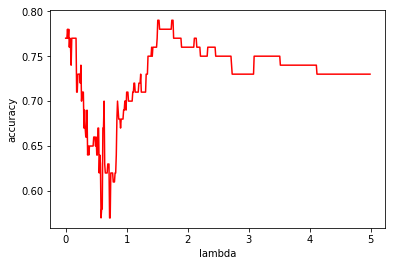

In [47]:
# question 11
x = np.arange(0, 5, 0.01)
accu=getAccuracy(reward_function1)
plt.plot(x, accu, 'r')
plt.xlabel('lambda')
plt.ylabel('accuracy')
plt.show()

In [60]:
# Q12
max_accu_1 = max(accu)
print('Maximum accuracy:',max_accu_1)
max_position = accu.index(max_accu_1)
lambda_max_1 = max_position*0.01
print('Lambda_max_1 =',lambda_max_1)

Maximum accuracy: 0.79
Lambda_max_1 = 1.51


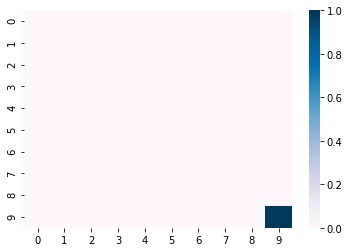

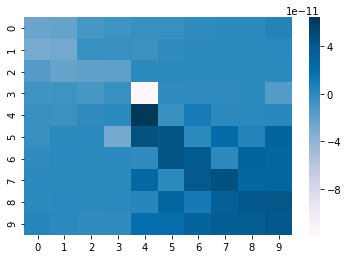

In [108]:
# Q13
# Ground truth reward: Reward function 1
heatmap_plot(reward_function1);
# Extracted reward is computed by solving the linear program with lambda_max_1
P_ss_a = tran_matrix(A)
P_ss_a = np.transpose(P_ss_a, (2, 0, 1))

opt_policy_value_1 = computation2(w=w, reward_function=reward_function1, number_of_states=100, discount_factor=discount_factor,
                          state_map=state_value_func_1);
extracted_reward_1 = IRL(100, 4, P_ss_a, opt_policy_value_1, discount_factor, reward_function1.max(), lambda_max_1)
heatmap_plot(extracted_reward_1);

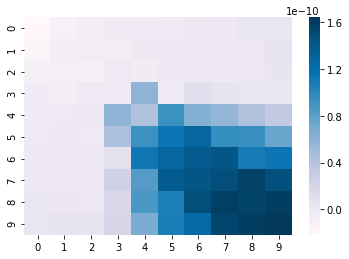

In [109]:
# Q14
opt_state_value_func_extracted_1 = optimal_state_value(w, extracted_reward_1, number_of_states, discount_factor, epsilon=0.01)
heatmap_plot(opt_state_value_func_extracted_1)

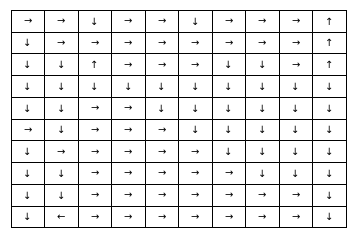

In [110]:
# Q16 
opt_policy_extracted_1 = computation(w=w, reward_function=extracted_reward_1, number_of_states=100, discount_factor=discount_factor, state_map=opt_state_value_func_extracted_1);
gridmap_plot(map=opt_policy_extracted_1, type=False)

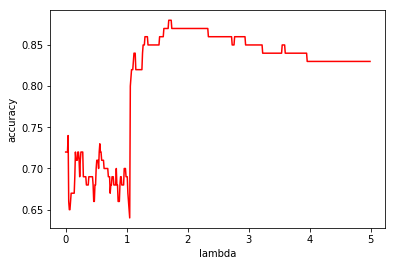

In [71]:
# Q18
x = np.arange(0, 5, 0.01)
accu_2=getAccuracy(reward_function2)
plt.plot(x, accu_2, 'r')
plt.xlabel('lambda')
plt.ylabel('accuracy')
plt.show()

In [74]:
# Q19
max_accu_2 = max(accu_2)
print('Maximum accuracy:',max_accu_2)
max_position = accu_2.index(max_accu_2)
lambda_max_2 = max_position*0.01
print('Lambda_max_2 =',lambda_max_2)

Maximum accuracy: 0.88
Lambda_max_2 = 1.69


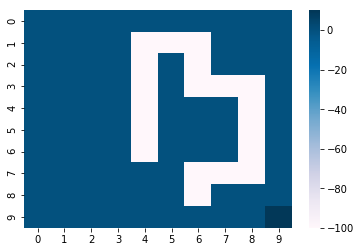

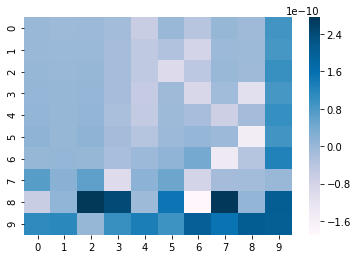

In [112]:
# Q20
# Ground truth reward: Reward function 2
heatmap_plot(reward_function2);
# Extracted reward is computed by solving the linear program with lambda_max_1

opt_policy_value_2 = computation2(w=w, reward_function=reward_function2, number_of_states=100, discount_factor=discount_factor,
                          state_map=state_value_func_2);
extracted_reward_2 = IRL(100, 4, P_ss_a, opt_policy_value_2, discount_factor, reward_function2.max(), lambda_max_2)
heatmap_plot(extracted_reward_2);

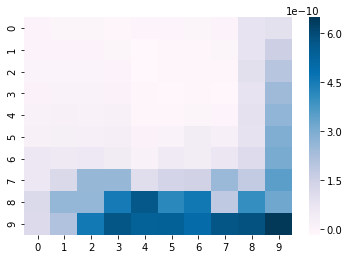

In [113]:
# Q21
opt_state_value_func_extracted_2 = optimal_state_value(w, extracted_reward_2, number_of_states, discount_factor, epsilon=0.01)
heatmap_plot(opt_state_value_func_extracted_2)

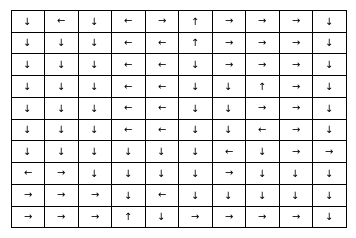

In [116]:
# Q23
opt_policy_extracted_2 = computation(w=w, reward_function=extracted_reward_2, number_of_states=100, discount_factor=discount_factor, state_map=opt_state_value_func_extracted_2);
gridmap_plot(map=opt_policy_extracted_2, type=False)